# Position Encoding
* https://www.tensorflow.org/text/tutorials/transformer
* https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
* https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/
* https://github.com/aliutkus/spe
* https://arxiv.org/abs/2105.08399
* https://bmild.github.io/fourfeat/

## Import modules 

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

A positional encoding is a finite dimensional representation of the location or “position” of items in a sequence. Given some sequence A = [a_0, …, a_{n-1}], the positional encoding must be some type of tensor that we can feed to a model to tell it where some value a_i is in the sequence A.

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 8.65964323e-01 ... 1.33352143e-04
  1.15478198e-04 1.15478198e-04]
 [2.00000000e+00 2.00000000e+00 1.73192865e+00 ... 2.66704286e-04
  2.30956397e-04 2.30956397e-04]
 ...
 [2.53000000e+02 2.53000000e+02 2.19088974e+02 ... 3.37380922e-02
  2.92159842e-02 2.92159842e-02]
 [2.54000000e+02 2.54000000e+02 2.19954938e+02 ... 3.38714444e-02
  2.93314624e-02 2.93314624e-02]
 [2.55000000e+02 2.55000000e+02 2.20820902e+02 ... 3.40047965e-02
  2.94469406e-02 2.94469406e-02]]


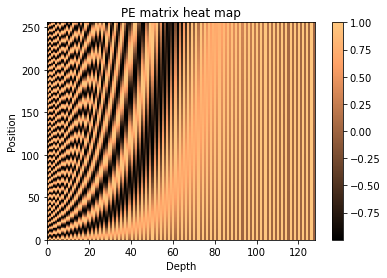

In [6]:
#### TensorFlow only version ####
def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = tf.range(max_position, dtype=tf.float32)
    mask = tf.range(d_model)
    sin_mask = tf.cast(mask%2, tf.float32)
    cos_mask = 1-sin_mask
    exponent = 2*(mask//2)
    exponent = tf.cast(exponent, tf.float32)/tf.cast(d_model, tf.float32)
    freqs = min_freq**exponent
    angles = tf.einsum('i,j->ij', position, freqs)
    pos_enc = tf.math.cos(angles)*cos_mask + tf.math.sin(angles)*sin_mask
    return pos_enc

#### Numpy version ####
def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
### Plotting ####
d_model = 128
max_pos = 256
mat = positional_encoding(max_pos, d_model)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.title("PE matrix heat map")
plt.colorbar()
plt.show()

## Relative positional encoding 

In [ ]:
def left_shift(x):
    dims = x.shape
    x = np.pad(x, [(0,0), (1,0)])
    x = x.reshape(dims[1]+1, dims[0])
    x = x[1:,:]
    x = x.reshape(*dims)
    return x.reshape(*dims)

def right_shift(x):
    dims = x.shape
    x = np.pad(x, [(0,0), (0,1)])
    x = x.reshape(dims[1]+1, dims[0])
    x = x[:-1,:]
    x = x.reshape(*dims)
    return x

def generate_samples(qlen, klen, d_model):
    q = np.random.randn(qlen, d_model)
    U = np.random.randn(klen, d_model)

    offset = klen-qlen # if klen>qlen, start qlen at offset position
    M = np.zeros((qlen, klen))
    for i in range(qlen):
        for j in range(klen):
            M[i,j] = q[i]@U[abs(i-j+offset)] # this is a vector dot product
    return M, q, U

def rel_position(q, U, direction='left'):
    if direction == 'left':
        return left_shift(q@np.flipud(U).T) # remember we need to reverse positions (up/down flip)
    
    if direction == 'right':
        m, n = q.shape[0], U.shape[0]
        if m < n:
            return np.pad(right_shift(q@U[:m-n].T), [(0,0), (n-m,0)])
        return right_shift(q@U.T)

    if direction=='both':
        m, n = q.shape[0], U.shape[0]        
        lower_mask, upper_mask = np.tril(np.ones((n,n)))[n-m:], np.triu(np.ones((n,n)), k=1)[n-m:]
        
        lower_diag = left_shift(q@np.flipud(U).T)

        if m < n:
            upper_diag = right_shift(q@U[:m-n].T)
            upper_diag = np.pad(upper_diag, [(0,0), (n-m,0)])
        else:
            upper_diag = right_shift(q@U.T)
            
        return upper_diag*upper_mask + lower_diag*lower_mask # these zero out the garbage parts
    
    else:
        raise ValueError("Incorrect direction entry.")

qlen = 3
klen = 5
d_model = 12
M, q, U = generate_samples(qlen, klen, d_model)
pred = rel_position(q, U, 'both')

In [ ]:
pred

In [ ]:
def relative_positions(length, maximum_position, with_cache=False):
    """Builds the relative positions.
    Args:
      length: The maximum length of the sequence.
      maximum_position: The maximum relative position to represent.
      with_cache: Set to ``True`` if this function is called from a multi-head
        attention layer with cache states.
    Returns:
      Positive relative positions with shape :math:`[T or 1, T]`.
    """
    if with_cache:
        distance = tf.expand_dims(tf.range(-length + 1, 1, delta=1), 0)
    else:
        arange = tf.range(length)
        distance = tf.expand_dims(arange, 0) - tf.expand_dims(
            arange, 1
        )  # Distance to the diagonal.
    distance = tf.clip_by_value(distance, -maximum_position, maximum_position)
    return distance + maximum_position  # Return positive indices.


def matmul_with_relative_representations(a, b, transpose_b=False):
    """Multiplies :obj:`a` with the relative representations :obj:`b`.
    Args:
      a: Tensor with shape :math:`[B, H, T, _]`.
      b: Tensor with shape :math:`[T, T, _]`.
    Returns:
      Tensor with shape :math:`[B, H, T, T]`.
    """
    batch, head, time, depth = misc.shape_list(a)
    a = tf.transpose(a, perm=[2, 0, 1, 3])
    a = tf.reshape(a, [time, batch * head, depth])
    c = tf.matmul(a, b, transpose_b=transpose_b)
    c = tf.reshape(c, [time, batch, head, c.shape[-1] or tf.shape(c)[-1]])
    c = tf.transpose(c, perm=[1, 2, 0, 3])
    return c


In [ ]:
rp = relative_positions(10,4)

In [ ]:
rp

##  Fourier feature position encodings

In [18]:
import math
from einops import rearrange, repeat

def fourier_encode(x, max_freq, num_bands=4, base=2):
    x = tf.expand_dims(x, -1)
    x = tf.cast(x, dtype=tf.float32)
    orig_x = x
    scales = tf.experimental.numpy.logspace(
        1.0,
        math.log(max_freq / 2) / math.log(base),
        num=num_bands,
        base=base,
        dtype=tf.float32,
    )
    scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

    x = x * scales * math.pi
    x = tf.concat([tf.math.sin(x), tf.math.cos(x)], axis=-1)
    x = tf.concat((x, orig_x), axis=-1)
    return x

In [54]:
def Encode(data, max_freq, num_freq_bands, freq_base, input_axis=3, mask=None):
    b, *axis = data.shape

    # assert (
    #         len(axis) == input_axis
    #     ), "input data must have the right number of axis"

    axis_pos = list(map(lambda size: tf.linspace(-1.0, 1.0, num=size), axis))
    pos = tf.stack(tf.meshgrid(*axis_pos, indexing="ij"), axis=-1)

    enc_pos = fourier_encode(
            pos, max_freq, num_freq_bands, base= freq_base
        )
    
    print(enc_pos.shape)
   
    enc_pos = rearrange(enc_pos, "... n d -> ... (n d)")
    enc_pos = repeat(enc_pos, "... -> b ...", b=b)
    
    print(enc_pos.shape)

    data = tf.concat((data, enc_pos), axis=-1)
    data = rearrange(data, "b ... d -> b (...) d")
    
    data = tf.concat((data, enc_pos), axis=-1)
    data = rearrange(data, "b ... d -> b (...) d")

    return data 
    

In [56]:
max_freq = 10. # maximum frequency, hyperparameter depending on how fine the data is
num_freq_bands = 10 # number of freq bands, with original value (2 * K + 1)
freq_base= 2
input_axis = 1

data = tf.ones((1,10,20))
data_encoded = Encode(data,max_freq,num_freq_bands,freq_base,input_axis)
print(data_encoded.shape)

(10, 20, 2, 21)
(1, 10, 20, 42)


InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [1,10,20] vs. shape[1] = [1,10,20,42] [Op:ConcatV2] name: concat